# Visualizations of the implemented metrics

### PDM

In [2]:
%matplotlib inline
from pathlib import Path
import itertools

from scipy import signal
import numpy as np
import torch
from omegaconf import OmegaConf
import IPython.display as ipd
import torchmetrics
from librosa.display import waveshow
from librosa.onset import onset_detect, onset_strength
import matplotlib.pyplot as plt

from utils.file_utils import rmdir_and_contents, resample_dir_if_needed, AudioLoudnessNormalize
from utils.dataset import AudioDataset


In [3]:
class PeakDetectionMetric(torchmetrics.Metric):
    def __init__(self, sample_rate: int) -> None:
        super().__init__()
        self.sample_rate = sample_rate
        self.normalize = AudioLoudnessNormalize(target_loudness=-24.0, sr=sample_rate)

        self.add_state("similarity", torch.tensor(0.0), dist_reduce_fx="sum")
        self.add_state("count", torch.tensor(0), dist_reduce_fx="sum")

    def update(self, gen_audios: torch.Tensor, gt_audios: torch.Tensor) -> None:
        """Update the similarity and count.

        Args:
            gen_audios (torch.Tensor): Generated audio [B, C, T].
            gt_audios (torch.Tensor): Ground truth audio [B, C, T].

        Returns:
            float: Similarity.
        """
        assert gen_audios.shape == gt_audios.shape, "Audio shapes must match."
        assert (
            gen_audios.shape[1] == 1 and gt_audios.shape[1] == 1
        ), "Audio must be mono."

        # normalize audios
        gen_audios = self.normalize(gen_audios)
        gt_audios = self.normalize(gt_audios)
        # BLAAAH, librosa does not support batching :(
        for gen_audio, gt_audio in zip(gen_audios, gt_audios):
            # picking peaks in an onset strength envelope
            gen_onset_strength = onset_detect(
                y=gen_audio.squeeze(0).numpy(), sr=self.sample_rate, normalize=False
            )
            gt_onset_strength = onset_detect(
                y=gt_audio.squeeze(0).numpy(), sr=self.sample_rate, normalize=False
            )

        # compute similarity
        # self.similarity += torchmetrics.functional.cosine_similarity(
        #     gen_peaks, gt_peaks
        # )
        self.count += torch.tensor(gen_audios.shape[0])

    def compute(self) -> float:
        """Compute the similarity.

        Returns:
            float: Similarity.
        """
        return self.similarity.item() / self.count.item()


In [4]:
cfg = OmegaConf.load("configs/pdm.yaml")
OmegaConf.resolve(cfg)
print(cfg)

gt_audio_dir = Path(cfg.gt_audio_dir)
gen_audio_dir = Path(cfg.gen_audio_dir)

gt_audio_dir_resampled, resampled_gt = resample_dir_if_needed(
    gt_audio_dir, cfg.sample_rate
)
gen_audio_dir_resampled, resample_gen = resample_dir_if_needed(
    gen_audio_dir, cfg.sample_rate
)

dataset = AudioDataset(
    audio_samples_dir=gen_audio_dir_resampled,
    audio_gts_dir=gt_audio_dir_resampled,
    duration=cfg.duration,
)
loader = torch.utils.data.DataLoader(
    dataset, batch_size=1, num_workers=cfg.num_workers, shuffle=False
)

# only get the first batch for debug purposes
iterator = iter(loader)
n = 7  # Replace with your value
batch = next(itertools.islice(iterator, n - 1, None))

pdm = PeakDetectionMetric(sample_rate=cfg.sample_rate)

gen_audio, gt_audio = batch["sample_audio"], batch["gt_audio"]


{'metric': 'pdm', 'gt_audio_dir': '/home/hdd/data/greatesthits/evaluation/gt_evaluation_files_debug', 'gen_audio_dir': '/home/hdd/data/greatesthits/evaluation/generated_files_debug', 'sample_rate': 24000, 'delete_resampled_dirs': True, 'duration': 2.0, 'batch_size': 10, 'num_workers': 10}


10it [00:00, 956.18it/s]
10it [00:00, 2853.85it/s]


Gen audio pre norm


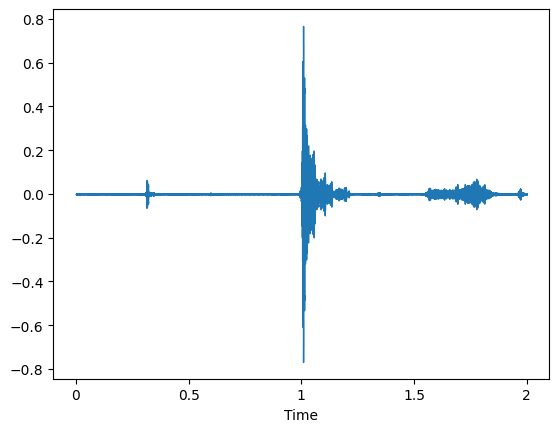

In [5]:
print("Gen audio pre norm")
waveshow(gen_audio.squeeze(0).numpy(), sr=cfg.sample_rate)
ipd.Audio(gen_audio.squeeze(0), rate=cfg.sample_rate)


GT audio pre norm


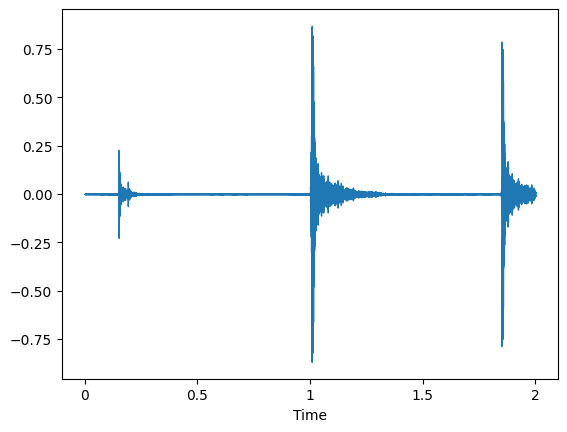

In [6]:
print("GT audio pre norm")
waveshow(gt_audio.squeeze(0).numpy(), sr=cfg.sample_rate)
ipd.Audio(gt_audio.squeeze(0), rate=cfg.sample_rate)


Gen audio post norm


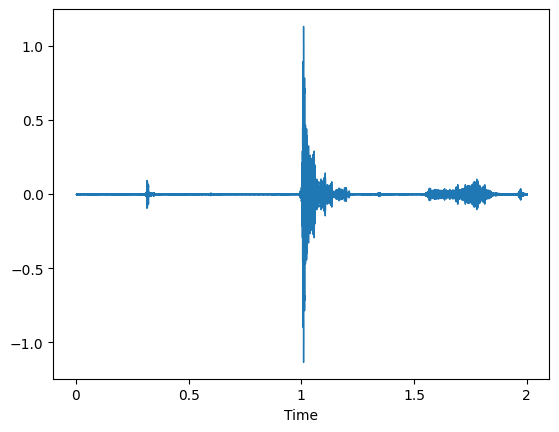

In [7]:
print("Gen audio post norm")
gen_audio = pdm.normalize(gen_audio)
waveshow(gen_audio.squeeze(0).numpy(), sr=cfg.sample_rate)
ipd.Audio(gen_audio.squeeze(0), rate=cfg.sample_rate)


GT audio post norm


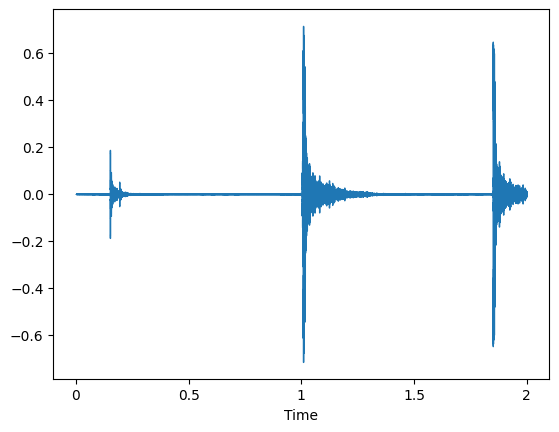

In [8]:
print("GT audio post norm")
gt_audio = pdm.normalize(gt_audio)
waveshow(gt_audio.squeeze(0).numpy(), sr=cfg.sample_rate)
ipd.Audio(gt_audio.squeeze(0), rate=cfg.sample_rate)


In [9]:
N = len(gen_audio[0, 0, :])
T = N / float(cfg.sample_rate)
t = np.linspace(0, T, N)


[ 7616 24064 37440 47232]


(0.0, 2.0)

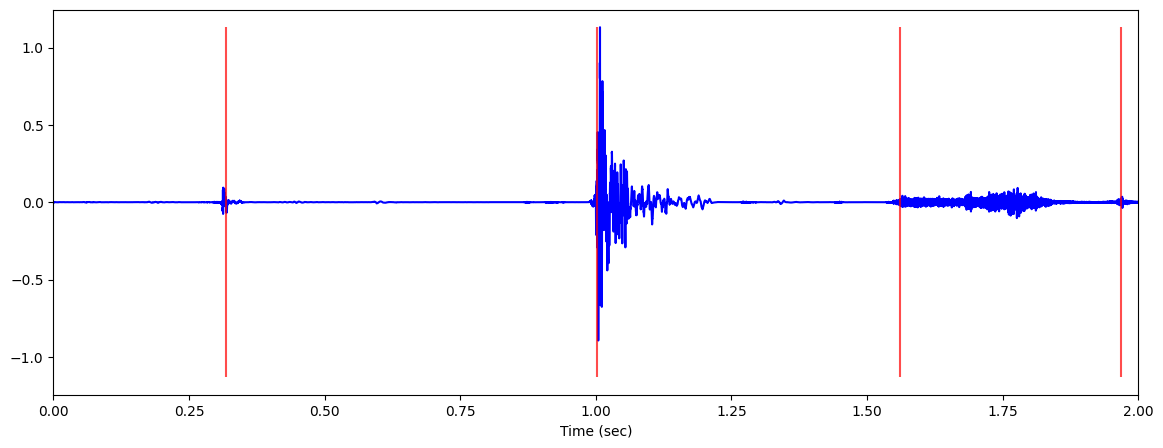

In [10]:
#  detect peaks and plot them
gen_onset_samples = onset_detect(
    y=gen_audio[0, 0, :].numpy(),
    sr=cfg.sample_rate,
    normalize=True,
    units="samples",
    hop_length=64,
)
print(gen_onset_samples)
plt.figure(figsize=(14, 5))
plt.plot(t, gen_audio[0, 0, :].numpy(), "b-", label="gen audio")
plt.grid(False)
plt.vlines(
    t[gen_onset_samples], -gen_audio.max(), gen_audio.max(), color="r", alpha=0.7
)
plt.xlabel("Time (sec)")
plt.xlim(0, T)


[ 3712 24128 44416]


(0.0, 2.0)

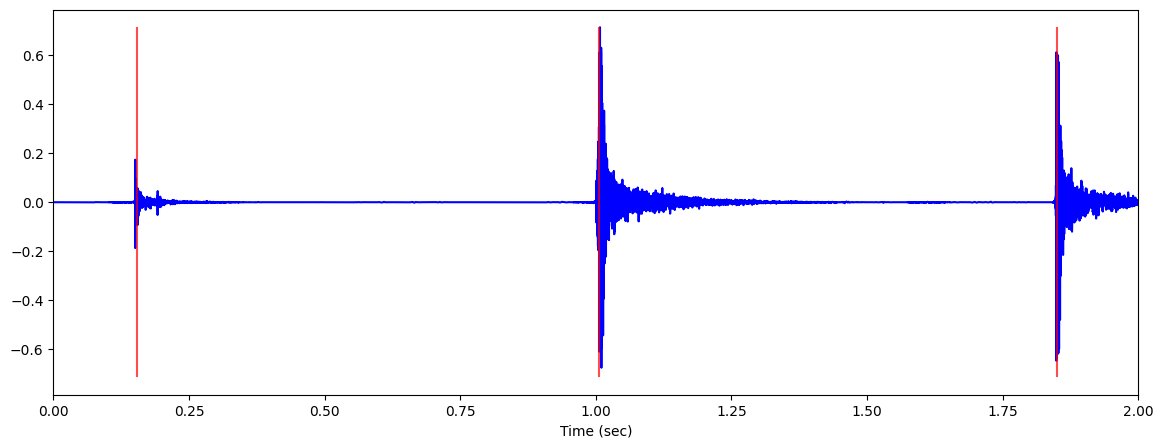

In [11]:
gt_onset_samples = onset_detect(
    y=gt_audio[0, 0, :].numpy(),
    sr=cfg.sample_rate,
    normalize=True,
    units="samples",
    hop_length=64,
)
print(gt_onset_samples)
plt.figure(figsize=(14, 5))
plt.plot(t, gt_audio[0, 0, :].numpy(), "b-", label="gen audio")
plt.grid(False)
plt.vlines(t[gt_onset_samples], -gt_audio.max(), gt_audio.max(), color="r", alpha=0.7)
plt.xlabel("Time (sec)")
plt.xlim(0, T)


### How about using cross correlation to find the lag?

In [12]:
def xcorr(x,y):
    """
    Perform Cross-Correlation on x and y
    x    : 1st signal
    y    : 2nd signal

    returns
    lags : lags of correlation
    corr : coefficients of correlation
    """
    corr = signal.correlate(x, y, mode="full")
    lags = signal.correlation_lags(len(x), len(y), mode="full")
    return lags, corr


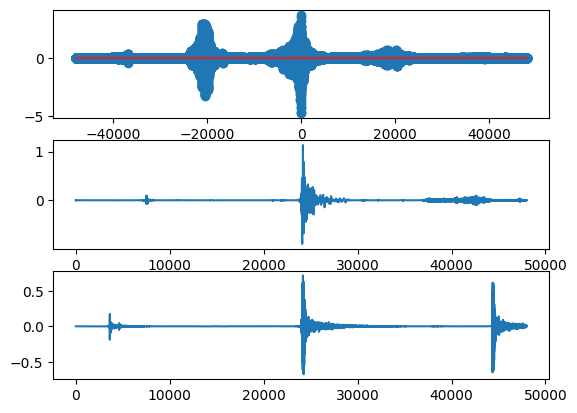

-80


In [38]:
# lags, corr = xcorr(
#     onset_strength(y=gen_audio[0, 0, :].numpy(), sr=cfg.sample_rate, hop_length=64),
#     onset_strength(y=gt_audio[0, 0, :].numpy(), sr=cfg.sample_rate, hop_length=64),
# )
lags, corr = xcorr(
    gen_audio[0, 0, :].numpy(),
    gt_audio[0, 0, :].numpy(),
)
# lags, corr = xcorr(
#     gen_onset_samples,
#     gt_onset_samples,
# )

fig, axs = plt.subplots(3)
axs[0].stem(lags, corr)
# axs[1].plot(onset_strength(y=gen_audio[0, 0, :].numpy(), sr=cfg.sample_rate, hop_length=64))
# axs[2].plot(onset_strength(y=gt_audio[0, 0, :].numpy(), sr=cfg.sample_rate, hop_length=64))
axs[1].plot(gen_audio[0, 0, :].numpy())
axs[2].plot(gt_audio[0, 0, :].numpy())
# axs[1].stem(gen_onset_samples, np.ones_like(gen_onset_samples))
# axs[2].stem(gt_onset_samples, np.ones_like(gt_onset_samples))
plt.show()

print(corr.argmax() - len(lags) // 2)


In [37]:
delay = np.abs(corr.argmax() - len(lags) // 2)
delay_s = delay / cfg.sample_rate
# larger the delay, smaller the score
score = delay_s
print(score)


0.0033333333333333335


In [14]:
if cfg.get("delete_resampled_dirs", True):
    if resampled_gt:
        rmdir_and_contents(gt_audio_dir_resampled)
    if resample_gen:
        rmdir_and_contents(gen_audio_dir_resampled)
